# Support Vector Machines

The exercises in this notebook clarify some topics around SVMs.

# Imbalanced Data
See Jason Brownlee's [treatment](https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/) at Machine Learning Mastery.

In [1]:
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [2]:
X,y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                         n_clusters_per_class=1, weights=[0.99],flip_y=0, random_state=4)

In [4]:
# As can be seen, 99% of the examples are in class 0 and 1% are in class 1, making a highly
# imbalaned dataset.
counter = Counter(y)
print(counter)

Counter({0: 9900, 1: 100})


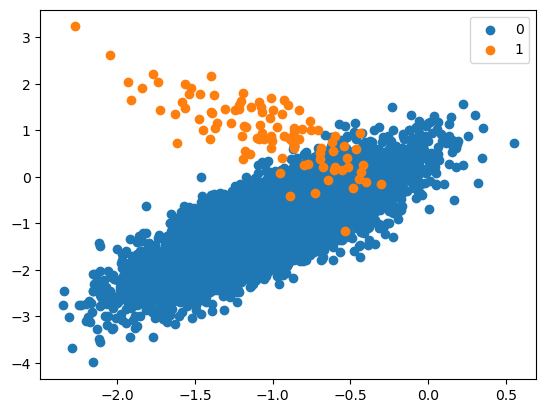

In [5]:
# Plot the data
for label, _ in counter.items():
    row_ix = where(y==label)[0]
    pyplot.scatter(X[row_ix,0],X[row_ix,1], label=str(label))
pyplot.legend()
pyplot.show()

Next we will try fitting an SVM on the imbalanced data set constructed above

In [6]:
# Imports
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC

In [7]:
# Model
model = SVC(gamma='scale')
# Cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# Evaluate
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.808


### Balanced SVM

Given a highly imbalanced dataset, the ```C``` parameter in SVM, which scores by the number of misclassifications, incentivies accuracy on the majority class, at the expense of the minority class.

In [9]:
# Model. 'balanced' class_weight this time. This causes the weighting of each example to be inverse proportionaly
# to the size of its class. This all classes have equal weight in the aggregate.
model = SVC(gamma='scale', class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Evaluate. Note that the score, as determined by the receiver-operater curve (ROC), is much better than
# for the unscaled version.
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.967


### SVM to determine weights by grid search

In [13]:
# Additional import needed
from sklearn.model_selection import GridSearchCV

In [17]:
# Parameters to use for the grid search.
# Above, we used 'balanced' for class weight. Here, we try five dictionaries for the weights.
#balance = [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
#param_grid = dict(class_weight=balance)

# I tried the following to see how SVM would perform with these degenerate cases, but it wouldn't work at all.
# balance = [{0:1,1:0}, {0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, {0:0, 1:1}]
# param_grid = dict(class_weight=balance)

# Here I added some extreme imbalances, though not degenerate.
balance = [{0:10000,1:1}, {0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, {0:1, 1:10000}]
param_grid = dict(class_weight=balance)

In [18]:
# SVM with grid search and cross-fold validation.
model = SVC(gamma='scale')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_result = grid.fit(X, y)

# Report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# Report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/michaelgoff/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.967747 using {'class_weight': {0: 1, 1: 100}}
0.742960 (0.149857) with: {'class_weight': {0: 10000, 1: 1}}
0.742960 (0.149857) with: {'class_weight': {0: 100, 1: 1}}
0.748404 (0.149873) with: {'class_weight': {0: 10, 1: 1}}
0.807960 (0.126354) with: {'class_weight': {0: 1, 1: 1}}
0.934401 (0.065202) with: {'class_weight': {0: 1, 1: 10}}
0.967747 (0.038637) with: {'class_weight': {0: 1, 1: 100}}
0.935892 (0.038022) with: {'class_weight': {0: 1, 1: 10000}}


In the above, notice that  the weight {0:1, 1:1}, which is equal weight for all points, is equivalent to specifying nothing for the ```class_weight``` parameter at all, and the score is roughly the same as it was for the first exercise above.

The first two class weight give more weight to examples in the majority class than from the minority class, which is the opposite of what we want. Consequently, the score is worse than it is for the unweighted version.

The best performance gives 100X the weight to examples of the second class, which has 1/100 the examples.

If the third set of weights is used above, notice how the ```{0: 1, 1: 10000}``` weight is too extreme, performing worse than the ```{0: 1, 1: 100}``` weight.

For the ```{0: 1, 1: 1}``` weight, what I don't understand is why we don't just classify all examples as in the majority class and get a score of 99%.